# Generalization 
# UNet with 3 encoder-decoder blocks trained on 80x80 CelebA images 

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import torch
from torch.utils.data import DataLoader

import os
import time                   
import sys
import argparse 

sys.path.insert(0, '../code') 
from network import UNet
from model_loader_func import load_UNet
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im
from quality_metrics_func import calc_psnr, im_set_corr
from linear_approx import calc_jacobian, traj_projections
from inverse_tasks_func import synthesis
from algorithm_inv_prob import univ_inv_sol
from dataloader_func import add_noise_torch

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.2.2


device(type='cuda')

## Load denoisers


In [5]:
## Load pretraiend denoisers 

denoisers_face = {}
# denoisers in group A are trained on one partision of the data which is non-overlapping with partision B
groups = ['A', 'B'] 
swap = False
training_data_name = 'img_align_celeba_80x80'

Ns = [1,10,100,1000, 10000,99325] #size of the dataset 

for group in groups: 
    print('loading group ' , group )
    denoisers_face[group] = {}
    if group == 'B': 
        swap = True
    for N in Ns:       
        start_time_total = time.time()        
        try: 
            denoisers_face[group][N] = load_UNet(
                           base_path = '../denoisers/UNet',
                           training_data_name= training_data_name, 
                           training_noise='0to255',
                           RF=90,
                           set_size=N, 
                           swap=swap);
        except FileNotFoundError: 
            pass 
        print("--- %s seconds ---" % (round(time.time() - start_time_total)))


loading group  A
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
loading group  B
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---


In [6]:
denoisers_face['A'].keys()

dict_keys([1, 10, 100, 1000, 10000, 99325])

## Load datasets 

In [8]:
###### Before running this cell, down the dataset from ??? into the datasets/img_align_celeba/ folder.
###### Dataset consist of CelebA images cropped to 160x160 and then downsampled to 80x80.
###### The RGB channels have been averaged to create grayscale images 

train_face ={}
test_face = {}
train_face['A'] = {}
train_face['B'] ={}
test_face['B'] = {}
test_face['A'] = {}

Ns = [1,10,100,1000, 10000,99325]

data = torch.load('/mnt/ceph/users/dlipshutz/datasets/celeb-faces/train80x80_no_repeats.pt')
K = data.shape[2] 
print(data.shape)
for N in Ns:
    train_face['A'][N] = data[0:N]
    test_face['A'][N] = data[-N::]
    train_face['B'][N] = data[-N::]
    test_face['B'][N] = data[0:N]   
    
     

torch.Size([198650, 1, 80, 80])


In [9]:
## rename N=99325 with N=100000 for ease of use later 
## Do not run this cell twice! 

denoisers_face['A'][100000] = denoisers_face['A'][99325]
del denoisers_face['A'][99325]   
denoisers_face['B'][100000] = denoisers_face['B'][99325]
del denoisers_face['B'][99325]  

train_face['A'][100000] = train_face['A'][99325]
del train_face['A'][99325]   
train_face['B'][100000] = train_face['B'][99325]
del train_face['B'][99325]  

test_face['A'][100000] = test_face['A'][99325]
del test_face['A'][99325]   
test_face['B'][100000] = test_face['B'][99325]
del test_face['B'][99325] 

Ns = list(denoisers_face['A'].keys())
print(Ns)

[1, 10, 100, 1000, 10000, 100000]


In [10]:
show_im_set(train_face['A'][10][0:10], n_columns=10, label='example training images')

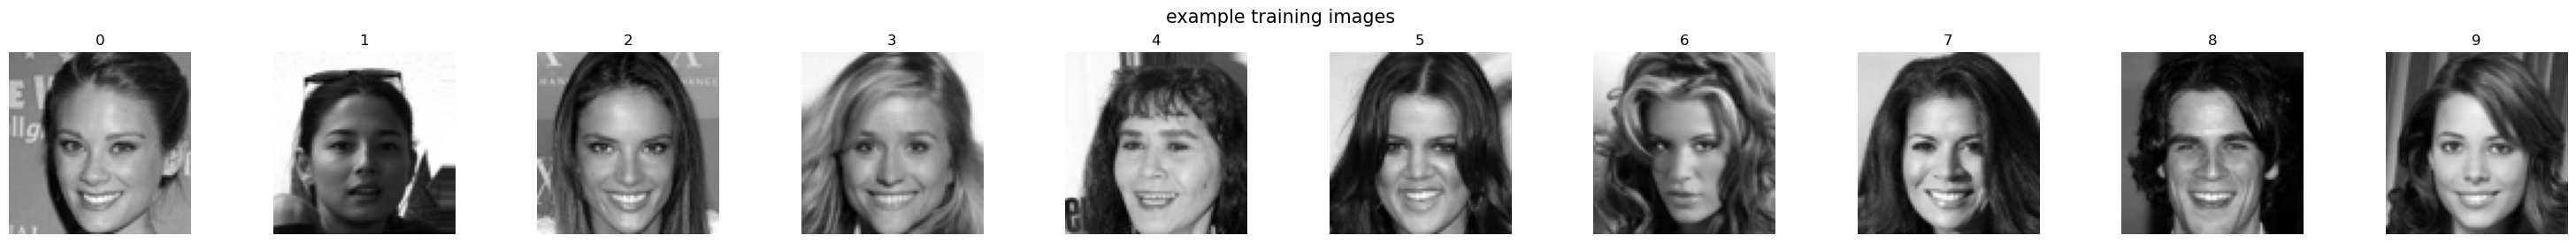

In [11]:
show_im_set(train_face['B'][10][0:10], n_columns=10, label='example training images')

# One shot denoising 

In [12]:
## compute psnr on test and train sets as a function of train set size N
sig_range = torch.logspace(.3,2.4,15)
psnr_test = {}
psnr_train = {}
for group in groups: 
    psnr_test[group] = {}
    psnr_train[group] = {}
    for N in Ns: 
        ## train 
        data = train_face[group][N]
        if N <300: 
            data = torch.tile(data, dims=(int(300/N) , 1,1,1))
        else: 
            data = data[0:300]        

        loader = DataLoader(dataset=data, batch_size=300, shuffle=False)
        try:
            print(N)
            psnr_train[group][N] = calc_psnr(denoisers_face[group][N],loader,sig_range , device)
        except KeyError: 
            pass

        ## test 
        data = test_face[group][1000][0:300]    
        loader = DataLoader(dataset=data, batch_size=300, shuffle=False)    
        try: 
            psnr_test[group][N] = calc_psnr(denoisers_face[group][N],loader,sig_range, device)
        except KeyError: 
            pass


1
10
100
1000
10000
100000
1
10
100
1000
10000
100000


1
10
100
1000
10000
100000


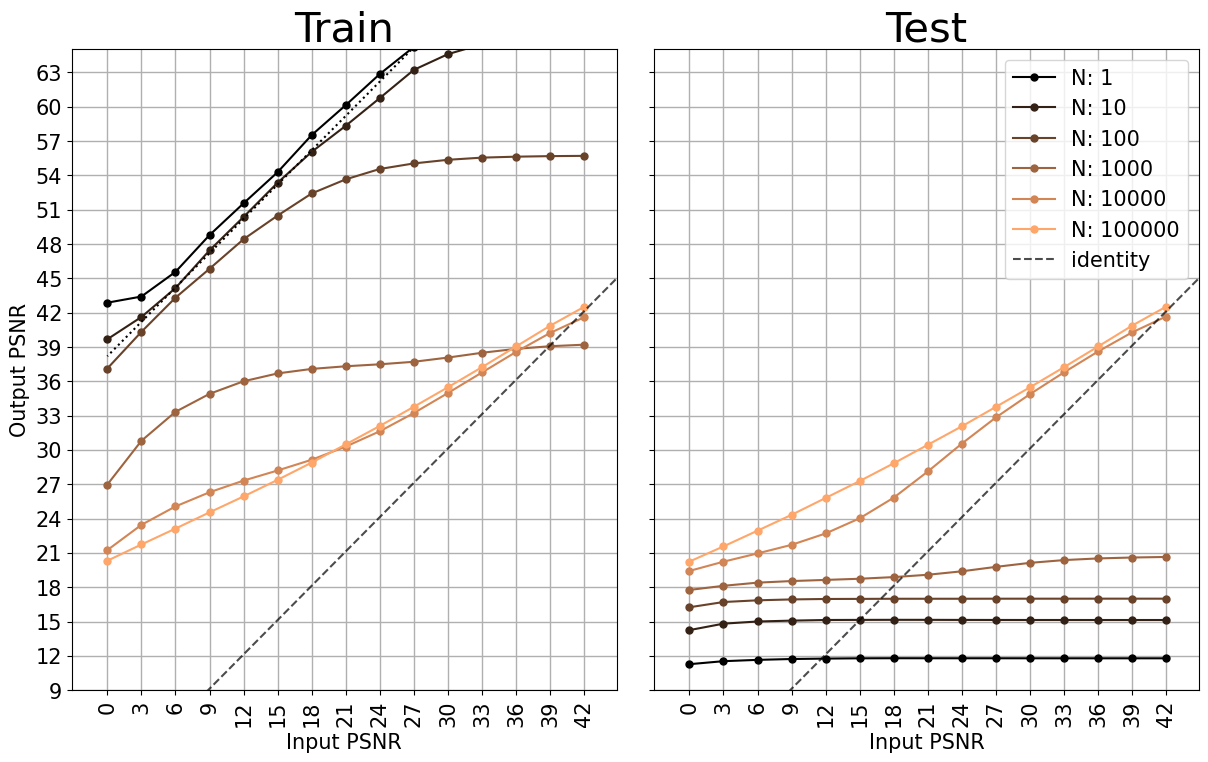

In [13]:
## plot 
group = 'B'
f , axs = plt.subplots(1,2, figsize=(12,7), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_train[group][1000].keys()]

for N in [1,10,100,1000,10000, 100000]: 
    print(N)
    ## train 
    axs[0].plot(x_axis, [psnr_train[group][N][key] for key in psnr_train[group][N].keys()], 
                marker = '.',markersize = 10, alpha = 1,label = 'N: '+ str(N))

    ## test 
    axs[1].plot(x_axis, [psnr_test[group][N][key] for key in psnr_test[group][N].keys()], 
                marker = '.',markersize = 10,label = 'N: '+ str(N), alpha = 1)
for i in range(2):
    axs[i].set_xticks(x_axis);
    axs[i].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    axs[i].set_xlim(-3, 45)
    
    axs[i].set_yticks(range(9,65,3) );    
    axs[i].set_yticklabels(range(9,65,3), fontsize=15);
    axs[i].set_ylim(9, 65)
    
    axs[i].grid(  linewidth=1);
    
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,len(Ns)+1)]
    for k,j in enumerate(axs[i].lines):
        j.set_color(plot_colors[k])
axs[0].plot(x_axis, [ -10*np.log10( (std/255)**2  ) for std in sig_range/K ],linestyle = 'dotted', color='black')
axs[0].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');
axs[1].plot( [0,65],[0,65] ,'k--', alpha = .7, label = 'identity');

axs[1].legend(fontsize = 15);
axs[0].set_title('Train', fontsize = 30)
axs[1].set_title('Test', fontsize = 30)
axs[0].set_xlabel('Input PSNR', fontsize = 15)
axs[0].set_ylabel('Output PSNR', fontsize = 15);
axs[1].set_xlabel('Input PSNR', fontsize = 15);


# denoise the same image once as the train image and once as the test image

In [14]:
### pick N 
N = 10000

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


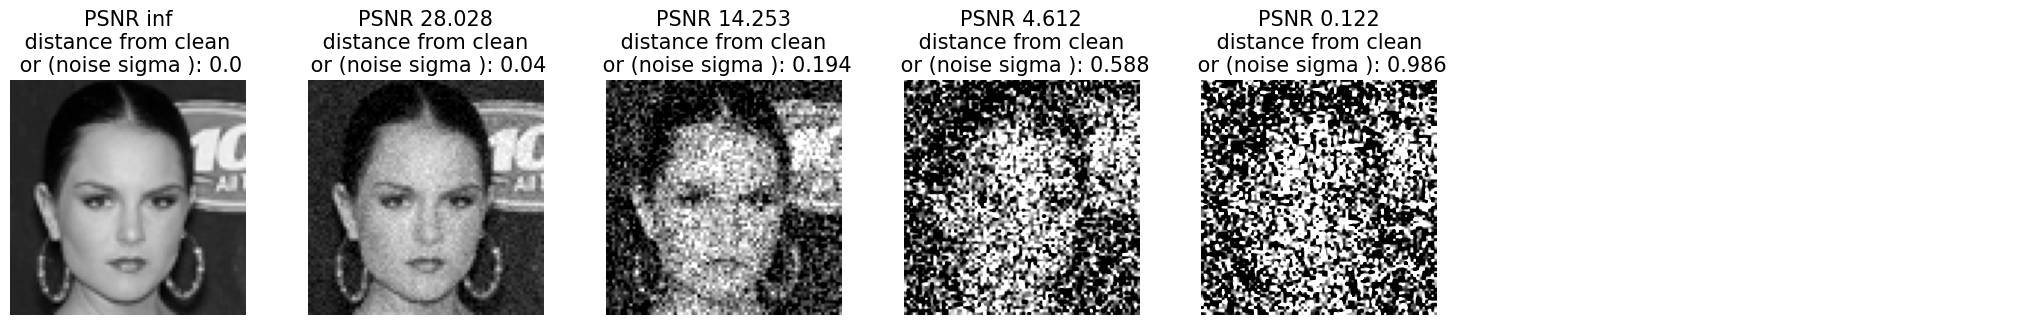

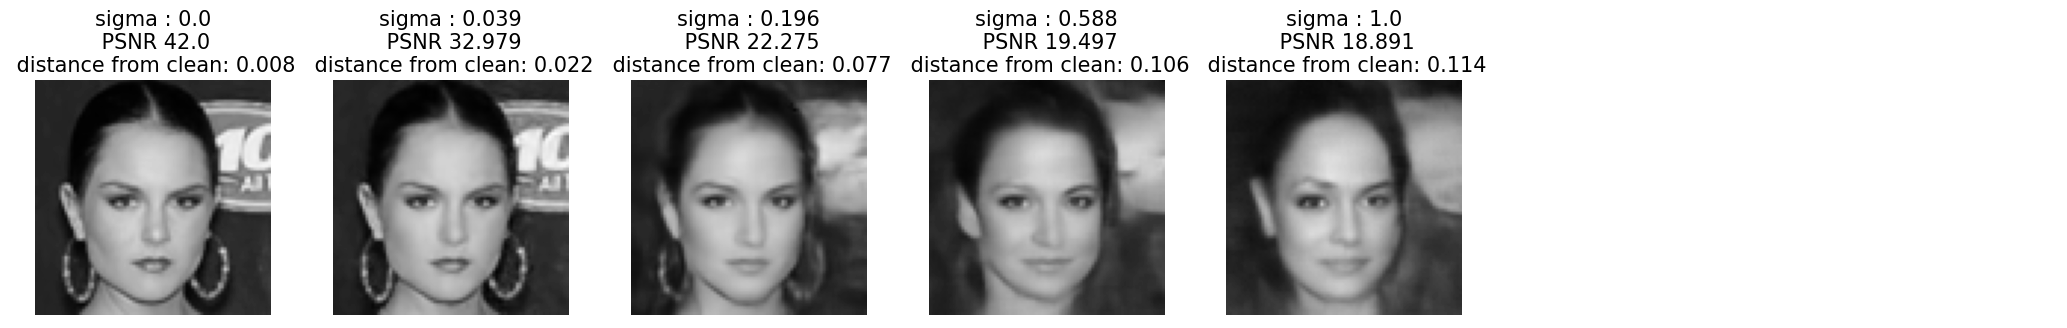

In [15]:
### denoise the same test image with different levels of noise using denoisers in the same group 

all_train_A_denoised = {}
all_noisy = {}

n = 0 # im number (must be smaller than N)
im = test_face['A'][N][n:n+1]

sigmas = torch.tensor([0,10,50,150, 255])
with torch.no_grad():
    for s in sigmas:
        s = np.round(s.item())
        noisy , _ = add_noise_torch( im , s )
        all_noisy[s] = noisy
        denoised_im = noisy.to(device) - denoisers_face['A'][N](noisy.to(device)).detach()
        
        all_train_A_denoised[np.round(s/255, 3)] = denoised_im
        if N ==1:
            print('expected distance: ', str(s/255/80 ))
### plot
plot_many_denoised(im, all_noisy, all_train_A_denoised ,device, 
                   suptitle = 'same denoiser, diff noise levels ', 
                   label='sigma : ', train= False, vmin=0, vmax=1, im_size=3)



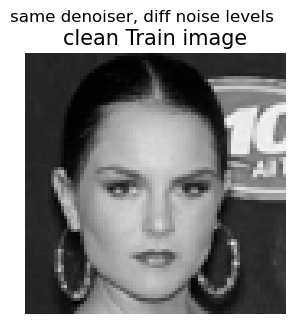

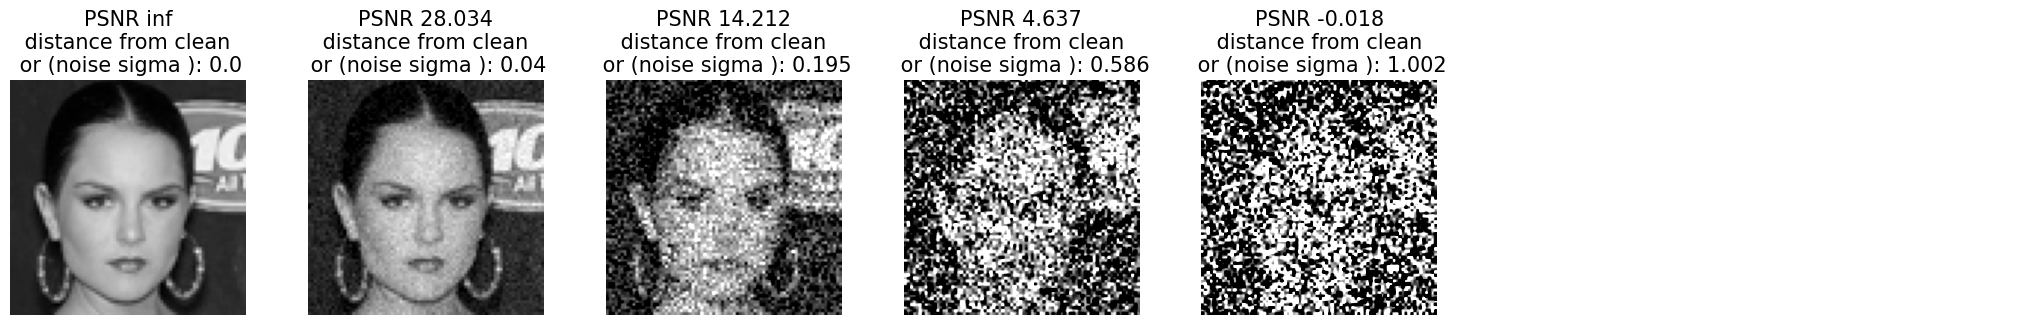

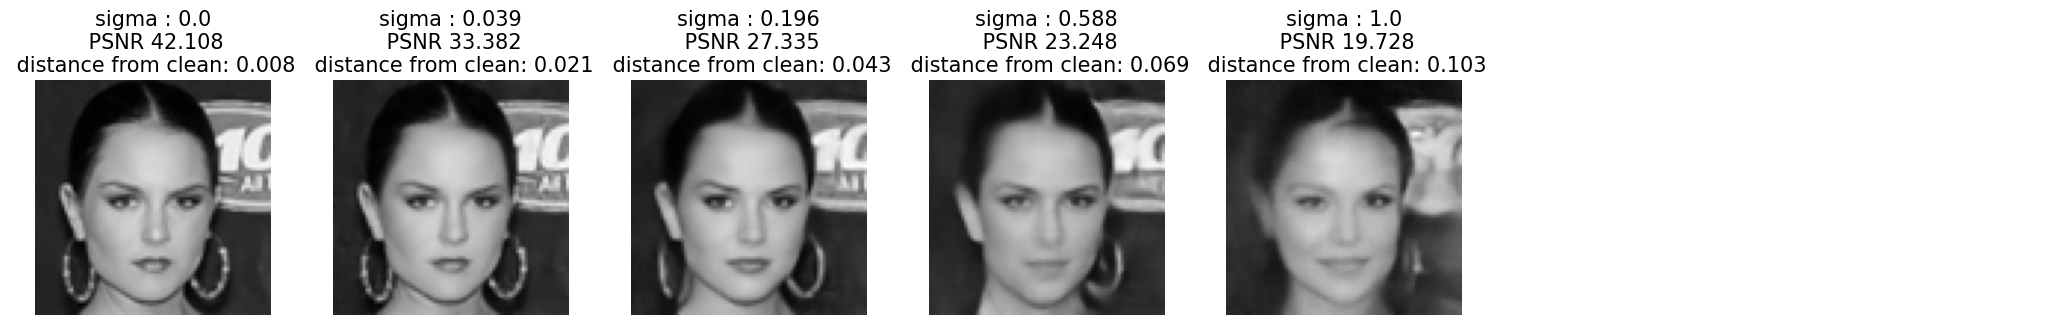

In [16]:
### Now the same image is a train image for denoisers in group B
### Performance on the same image when it is a train image 
all_train_A_denoised = {}
all_noisy = {}


sigmas = torch.tensor([0,10,50,150, 255])
with torch.no_grad():
    for s in sigmas:
        s = np.round(s.item())
        noisy , _ = add_noise_torch( im , s )
        all_noisy[s] = noisy
        denoised_im = noisy.to(device)-denoisers_face['B'][N](noisy.to(device)).detach()
        
        all_train_A_denoised[np.round(s/255, 3)] = denoised_im
        if N ==1:
            print('expected distance: ', str(s/255/80 ))
### plot
plot_many_denoised(im, all_noisy, all_train_A_denoised ,device, 
                   suptitle = 'same denoiser, diff noise levels ', 
                   label='sigma : ', train= True, vmin=0, vmax=1, im_size=3)



# Jacobian Analysis 

Choose one image and a denoiser to perform the Eigen analysis and visualize the basis 

In [17]:
# Pick the group, N, and image number

group = 'A'
n = 17 # image number 
N = 100000 #training set size to determine the denoiser 
im = test_face[group][N][n:n+1].to(device)
plot_single_im(im)

In [18]:
sigma = 40/255

noise = torch.randn(1,1,K,K).to(device)*sigma 
noisy = im + noise
denoised =  noisy - denoisers_face[group][N](noisy).detach()


In [19]:

f , axs = plt.subplots(1,3 , figsize=(9,3))
f.tight_layout()


fig = axs[0].imshow(im.squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[0].set_title('Clean', fontsize=30)

fig = axs[1].imshow(noisy.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[1].set_title('Noisy', fontsize=30)

fig = axs[2].imshow(denoised.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[2].set_title('Denoised', fontsize=30);


In [20]:
# compute the Jacobian 

I = torch.eye(K**2).to(device)
J = calc_jacobian(noisy, denoisers_face[group][N])
U,S, V = torch.svd(I - J)

In [21]:
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U[:,j], im.flatten() ).cpu() )
cors = torch.stack(cors)  

f, ax1 = plt.subplots(1,1, figsize = (7,5), sharey=False )
plt.tight_layout()

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '*', label = r'$ \langle x,e_k\rangle $', alpha = 1)
ax1.set_ylabel(r'$\langle x,e_k\rangle $', color=color,fontsize = 30)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color=color, fontsize = 30, rotation=90)
ax2.plot(S.cpu(), '.', alpha = 1, color=color);

plt.yticks( fontsize = 15);



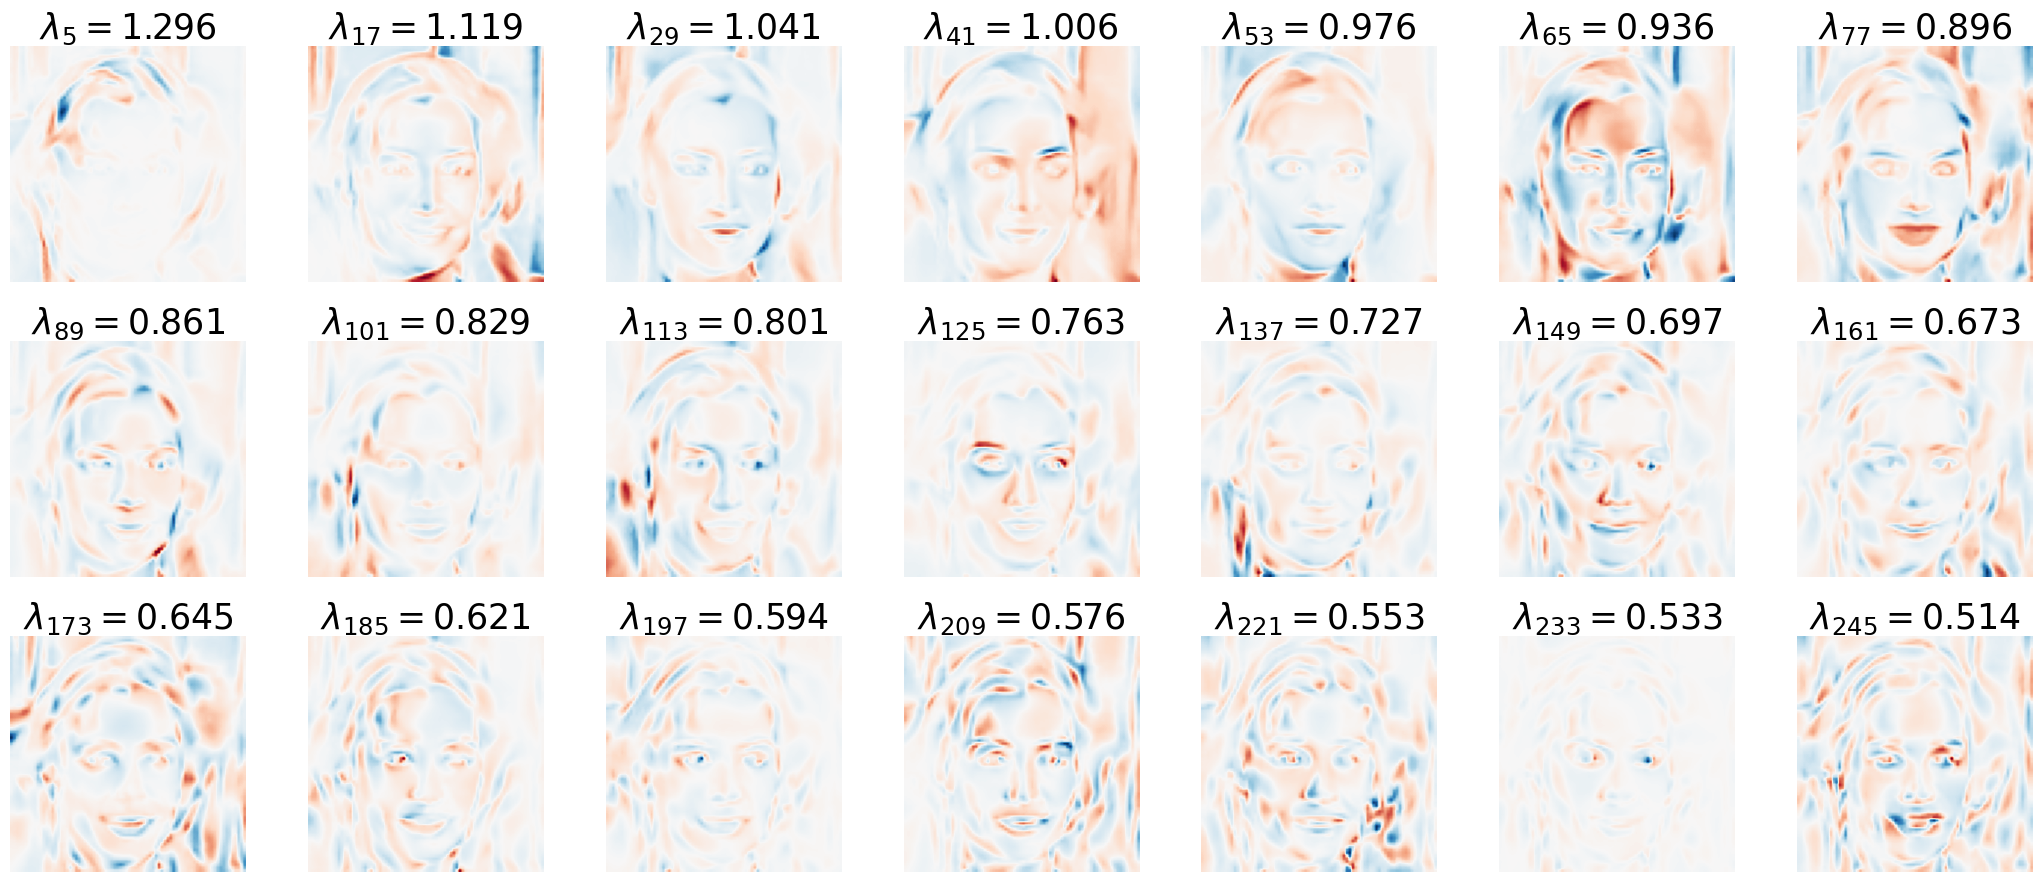

In [22]:
ids = range(5,12*21,12)

k = 21
skips = 1
shift = 0

f, axs = plt.subplots(int(k/7),7, figsize = (7*3,int(k/7)*3))
plt.tight_layout()
axs = axs.ravel()


for i in range(k): 
    j = ids[i]
    axs[i].imshow(-U[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 'RdBu',norm=colors.CenteredNorm())
    axs[i].set_title(r'$\lambda_{'+str(j)+'}=$' +str(round(S[j].cpu().item() ,3)) , fontsize = 25)
for i in range(len(axs)): 
    axs[i].axis('off');

    

In [23]:
## pick a denoiser in the memorization regime 
## pick a train image 

N = 10
n= 7
im = train_face[group][N][n:n+1].to(device)

sigma = 40/255
noise = torch.randn(1,1,K,K).to(device)*sigma 
noisy = im + noise
denoised =  noisy - denoisers_face[group][N](noisy).detach()

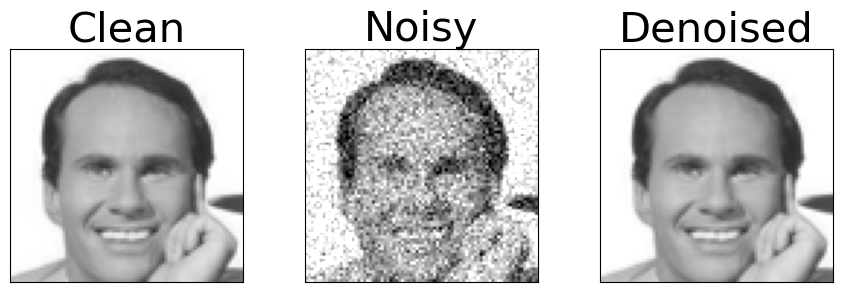

In [24]:

f , axs = plt.subplots(1,3 , figsize=(9,3))
f.tight_layout()


fig = axs[0].imshow(im.squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[0].set_title('Clean', fontsize=30)

fig = axs[1].imshow(noisy.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[1].set_title('Noisy', fontsize=30)

fig = axs[2].imshow(denoised.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[2].set_title('Denoised', fontsize=30);


In [25]:
# compute the Jacobian 

I = torch.eye(K**2).to(device)
J = calc_jacobian(noisy, denoisers_face[group][N])
U,S, V = torch.svd(I - J)

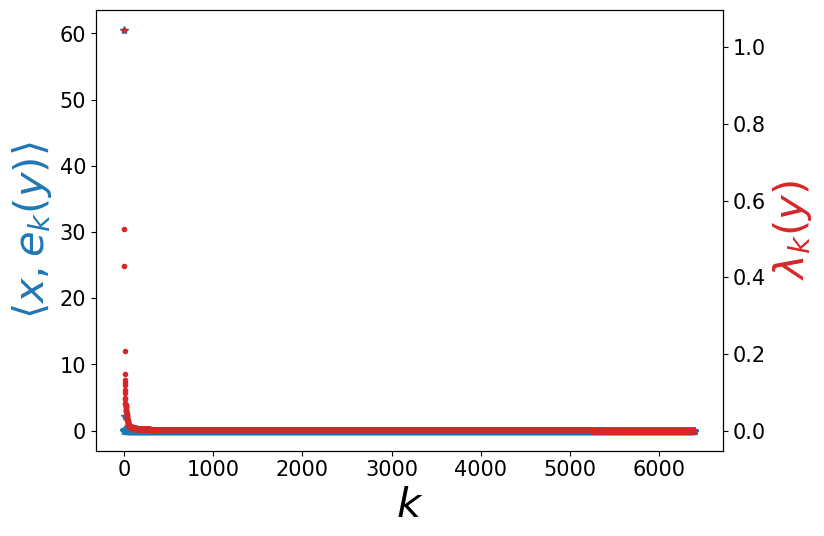

In [26]:
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U[:,j], im.flatten() ).cpu() )
cors = torch.stack(cors)  

f, ax1 = plt.subplots(1,1, figsize = (7,5), sharey=False )
plt.tight_layout()

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '*', label = r'$ \langle x,e_k\rangle$', alpha = 1)
ax1.set_ylabel(r'$\langle x,e_k(y)\rangle $', color=color,fontsize = 30)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color=color, fontsize = 30, rotation=90)
ax2.plot(S.cpu(), '.', alpha = 1, color=color);

plt.yticks( fontsize = 15);


In [27]:
k = 21
ids = range(0,k)
f, axs = plt.subplots(int(k/7),7, figsize = (7*3,int(k/7)*3))
plt.tight_layout()
axs = axs.ravel()


for i in range(k): 
    j = ids[i]
    axs[i].imshow(-U[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 'RdBu',norm=colors.CenteredNorm())
    axs[i].set_title(r'$\lambda_{'+str(j)+'}=$' +str(round(S[j].cpu().item() ,3)) , fontsize = 25)
for i in range(len(axs)): 
    axs[i].axis('off');

    

# Synthesis 

# Compare samples from two sets of denoisers 

In [28]:
# generate samples starting from all_interm_Ysme seed using both denoisers 
                                                                                                        
synth = synthesis() 
samples_faces = {}
all_interm_Ys = {}
seed = 0
for group in groups: 
    samples_faces[group] = {}
    all_interm_Ys[group] = {}
    for N in Ns: 
        torch.manual_seed(seed)
        sample, interm_Ys,all_sigs, all_means =univ_inv_sol(denoisers_face[group][N], 
                                                             x_c= torch.zeros(1,K,K).cuda(),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01 , 
                                                             beta=.1 , 
                                                             freq=0,
                                                             seed = seed, 
                                                             init_im = train_face[group][N].mean(dim=0).cuda()+ torch.randn(1,K,K, device = device), 
                                                             init_noise_mean=0,
                                                             max_T=2000, 
                                                             fixed_h=False)

        samples_faces[group][N] = sample.detach()
        all_interm_Ys[group][N] = interm_Ys


-------- final sigma,  0.09643182903528214
-------- final mean  0.7135072350502014
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0022
-------- final sigma,  0.09802001714706421
-------- final mean  0.22317370772361755
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.09798949211835861
-------- final mean  0.3220864534378052
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.0981440469622612
-------- final mean  0.4469323754310608
-------- total number of iterations,  84 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.097504623234272
-------- final mean  0.46054670214653015
-------- total number of iterations,  77 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.09668879210948944
-------- final mean  0.4606429934501648
-------- total number of iterations,  76 -------- ave

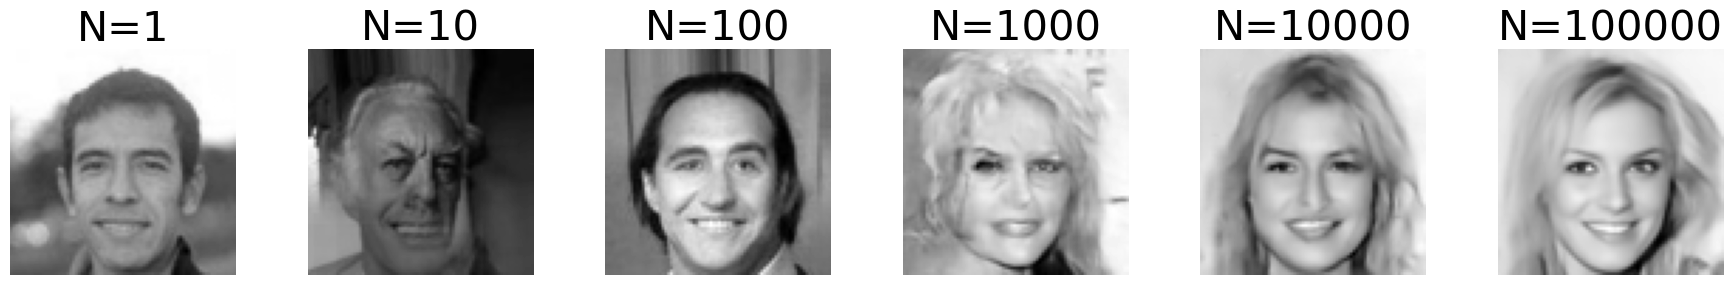

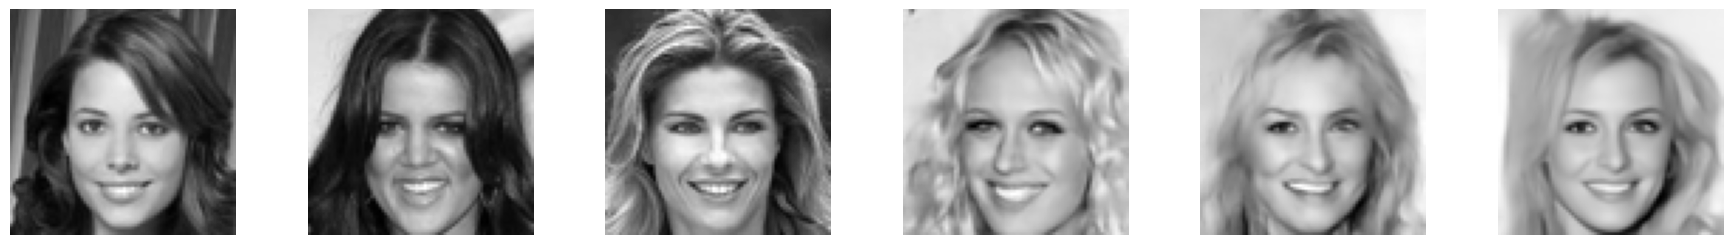

In [29]:

group = 'A'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=6)
group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*6 , n_columns=6)


In [30]:
closest_train = {}
for group in groups: 
    closest_train[group] = []
    for N in Ns:
        corrs = im_set_corr(samples_faces[group][N].unsqueeze(0).to(device), 
                            train_face[group][N].to(device), remove_mean=True)
        values, indices = corrs.max(dim = 1)
        closest_train[group].append(train_face[group][N][indices.cpu()])

<Figure size 640x480 with 0 Axes>

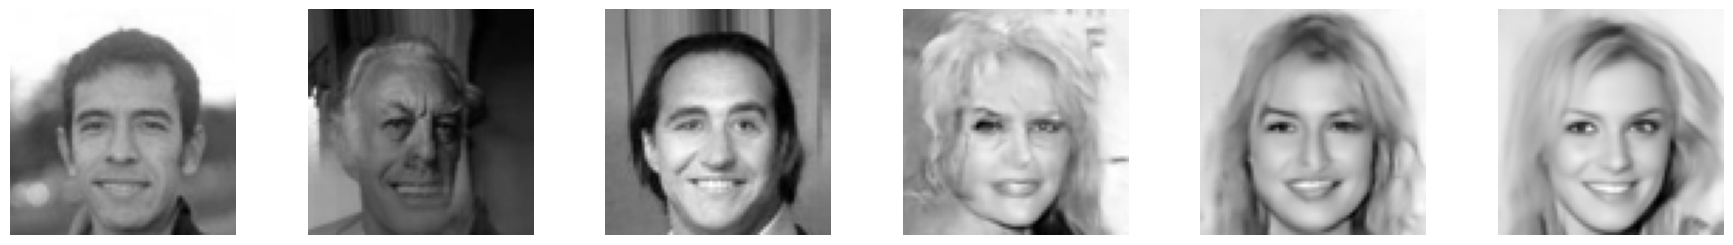

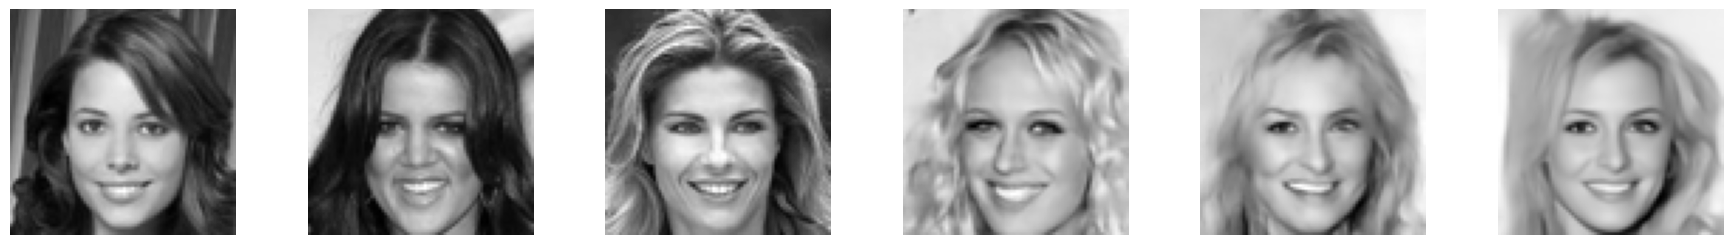

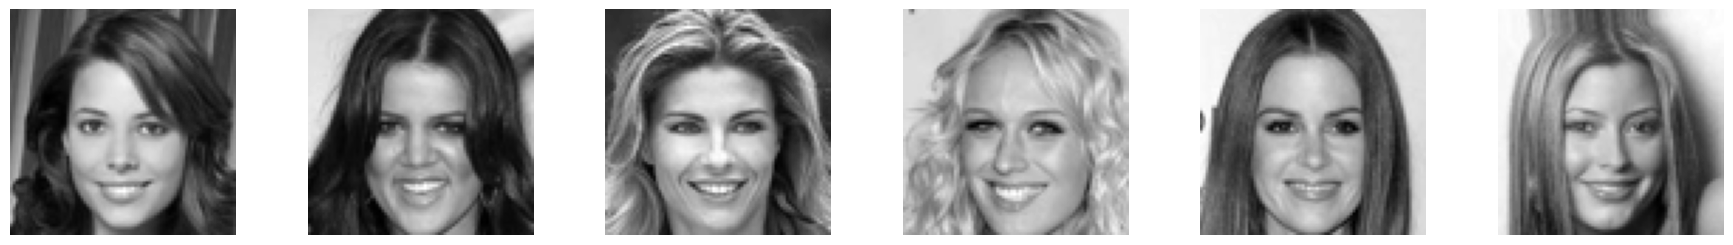

In [31]:
plt.figure()
group = 'A'
show_im_set(torch.vstack(closest_train[group]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=6)
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*6, n_columns=6)

group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*6 , n_columns=6)
show_im_set(torch.vstack(closest_train[group]), label='',sub_labels= ['']*6 , n_columns=6);


In [32]:
#Generate many samples from a pair of denoisers trained on N images 
N = 100000
n_samples = 20
shift = 0
seeds = range(shift,shift+n_samples)
freq =10

all_samples = {}
all_interm_Ys = {}
all_sigmas={}
all_means = {}

start_time_total = time.time()
synth = synthesis()

for group in groups: 
    print('------------ group: ', group)
  
    all_samples[group] = torch.zeros(n_samples, 1, K,K).to(device)
    all_interm_Ys[group] = []
    all_sigmas[group] = []
    all_means[group] = [] 
    
    for n in range(n_samples): 
        print('--------- N : ', N)        
        torch.manual_seed(seeds[n])
        sample, interm_Ys,sigmas, means =univ_inv_sol(denoisers_face[group][N], 
                                                             x_c= torch.zeros(1,K,K).cuda(),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01 , 
                                                             beta=.1 , 
                                                             freq=freq,
                                                             seed = seeds[n], 
                                                             init_im = train_face[group][N].mean(dim=0).cuda() + torch.randn(1,K,K, device = device), 
                                                             init_noise_mean=0,
                                                             max_T=10000, 
                                                             fixed_h=False)
        all_samples[group][n, 0] = sample.detach()
        all_interm_Ys[group].append(interm_Ys)
        all_sigmas[group].append(sigmas)
        all_means[group].append(means)
        
print("--- %s seconds ---" % (time.time() - start_time_total))

------------ group:  A
--------- N :  100000
----------------------------- 10
sigma  1.0520219802856445
mean  0.42094069719314575
----------------------------- 20
sigma  0.9194256663322449
mean  0.4187971353530884
----------------------------- 30
sigma  0.7664842009544373
mean  0.429596483707428
----------------------------- 40
sigma  0.5526595115661621
mean  0.42888182401657104
----------------------------- 50
sigma  0.3850831091403961
mean  0.44562822580337524
----------------------------- 60
sigma  0.23877476155757904
mean  0.44925352931022644
----------------------------- 70
sigma  0.13681595027446747
mean  0.4599059820175171
-------- final sigma,  0.09668879210948944
-------- final mean  0.4606429934501648
-------- total number of iterations,  76 -------- average time per iteration (s),  0.0022
--------- N :  100000
----------------------------- 10
sigma  1.0762578248977661
mean  0.4219501316547394
----------------------------- 20
sigma  0.9126152396202087
mean  0.4352134466171264

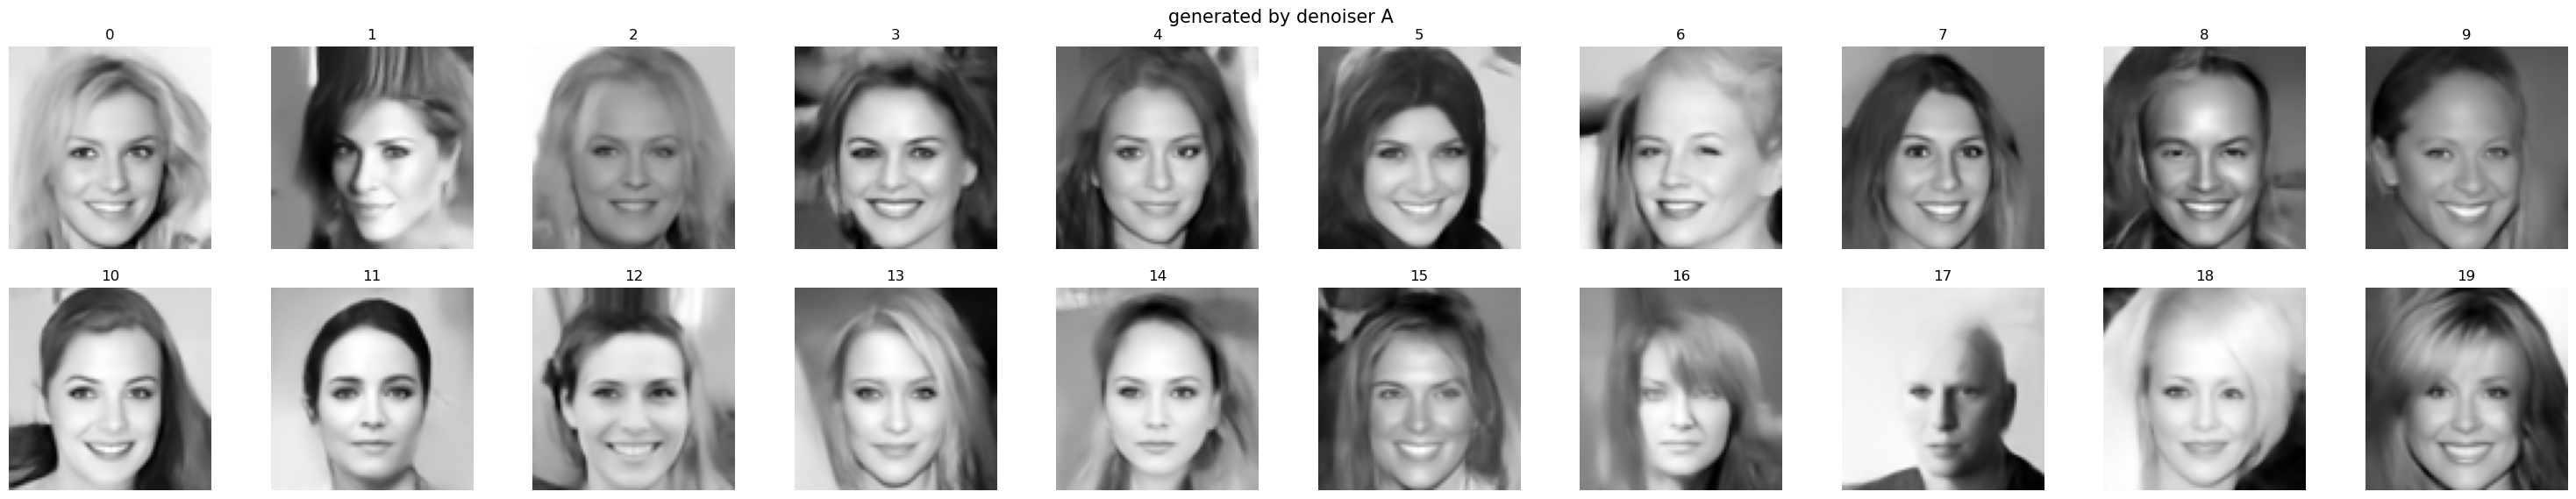

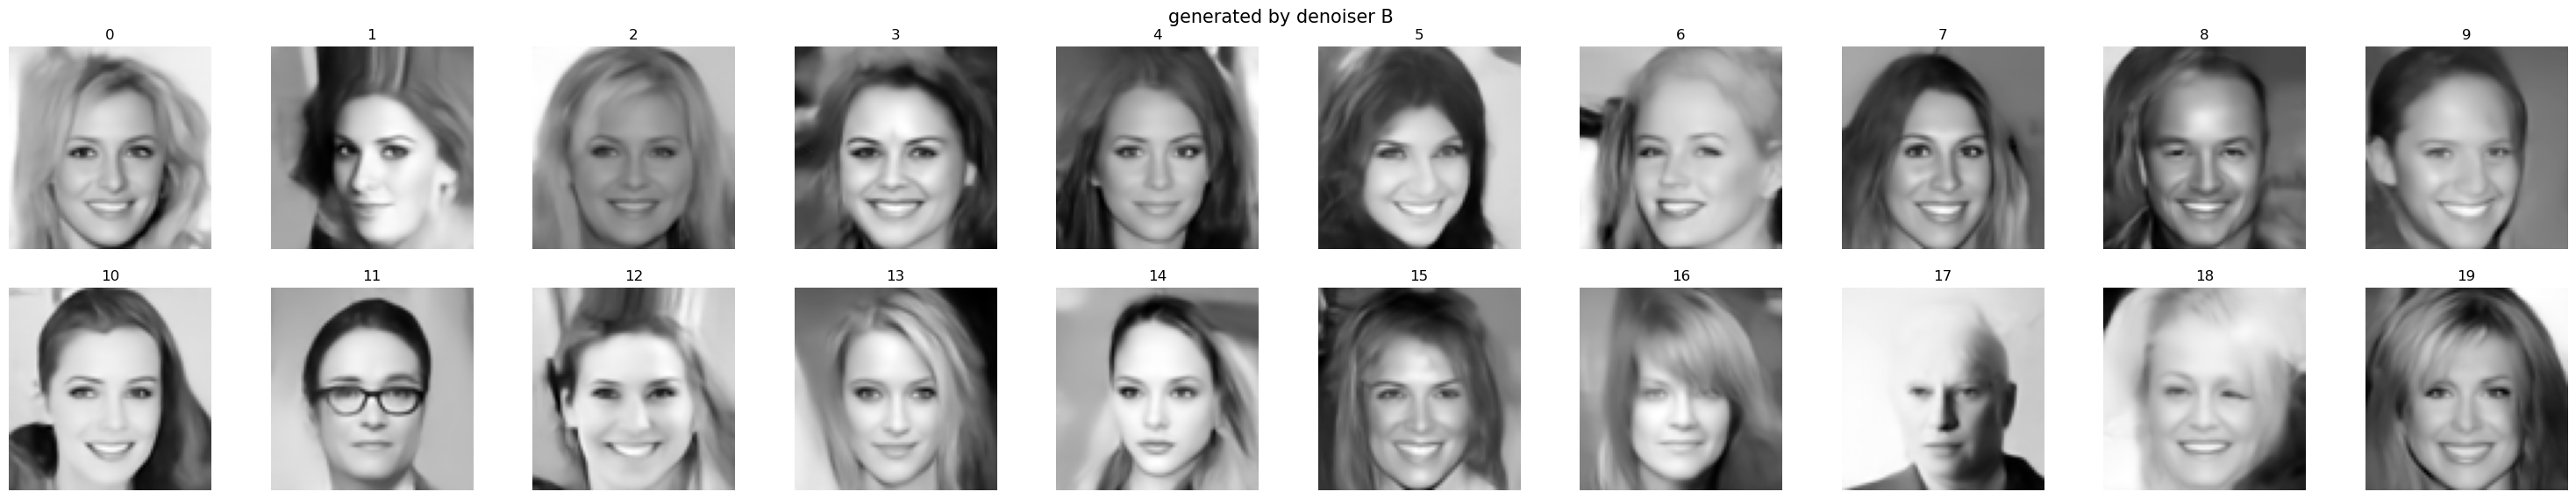

In [33]:
show_im_set(all_samples['A'], n_columns=10 , label='generated by denoiser A')
show_im_set(all_samples['B'], n_columns=10 , label='generated by denoiser B')

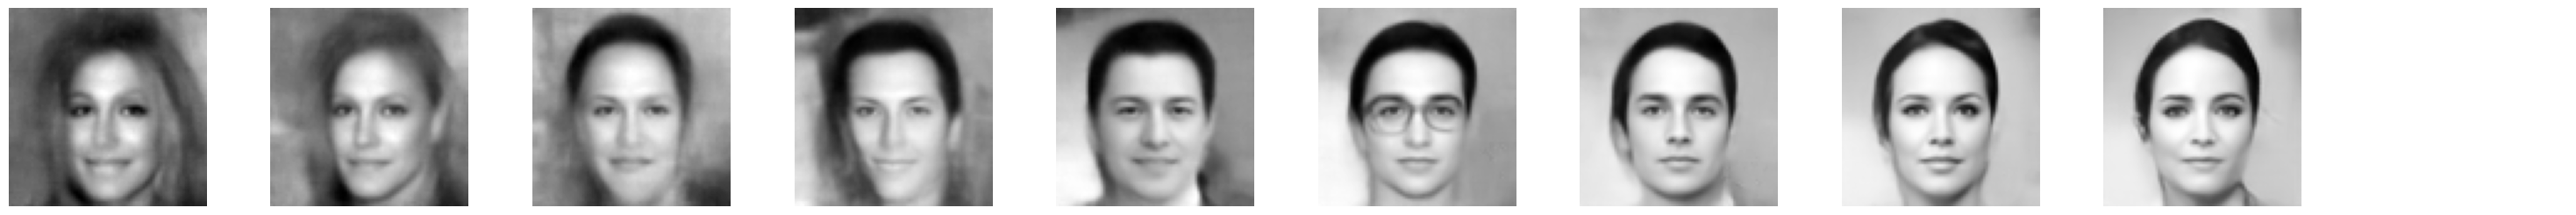

In [34]:
n = 11
group = 'A'
show_im_set(traj_projections(torch.stack(all_interm_Ys[group][n]) , denoisers_face[group][N]), 
             n_columns=10, font_size=10, colorbar=False, label='',sub_labels=['']*10)


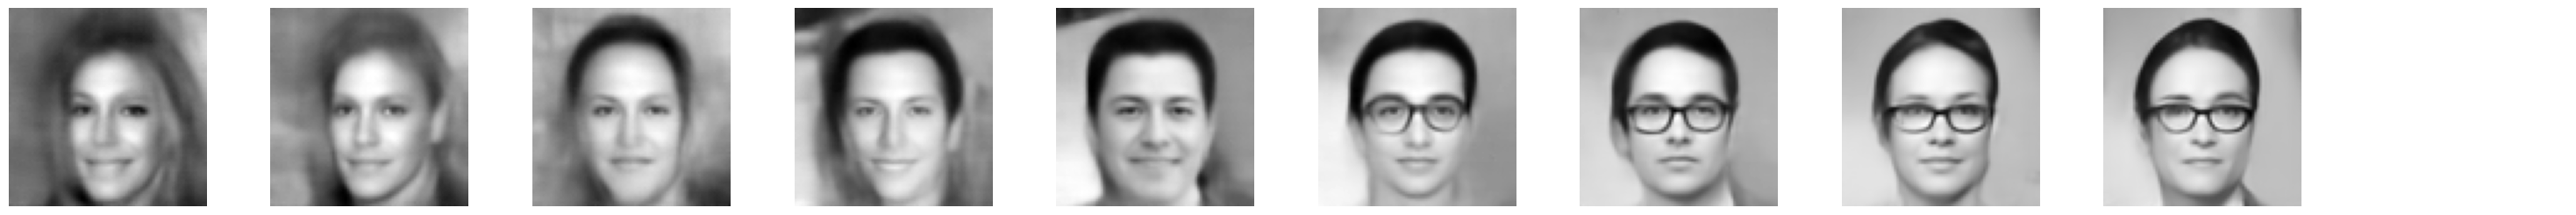

In [35]:
group = 'B'
show_im_set(traj_projections(torch.stack(all_interm_Ys[group][n]) , denoisers_face[group][N]), 
             n_columns=10, font_size=10, colorbar=False, label='', sub_labels=['']*10)


# pairs cosine similarities 
saved samples 

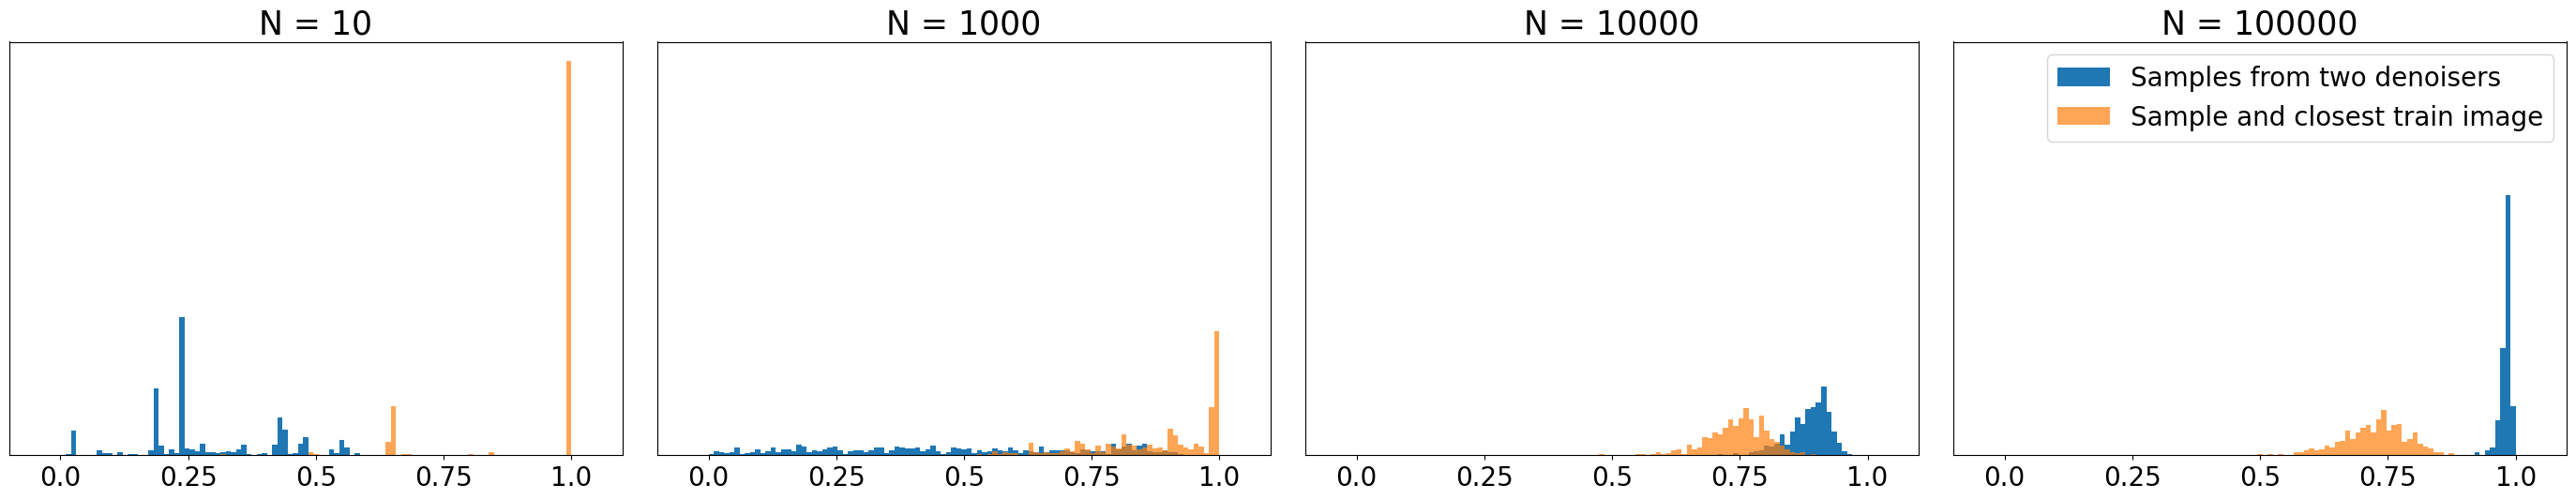

In [36]:

f, ax = plt.subplots(1,4, figsize = (7*4,5) , sharey = True)
plt.tight_layout()
i = 0
for N in [10,1000,10000,100000]: 
    
    many_samples_faces = torch.load('../results/img_align_celeba_80x80/UNet_many_samples_'+str(N) +'.pt',
                                   map_location=torch.device('cpu'))
    sims = im_set_corr ( (many_samples_faces['A']) , (many_samples_faces['B']) ).diag()
    bins = np.linspace(0.,1. ,100)

    ax[i].hist(sims.cpu().flatten(), bins = bins, label='Samples from two denoisers', alpha = 1, density=True)

    # compute correlations between generated samples and closest images from the train set 
    corrs = im_set_corr((many_samples_faces['A']).to(device), (train_face['A'][N].to(device)) )
    values, indices = corrs.max(dim = 1)
    ax[i].hist(values.cpu() , bins = bins, label = 'Sample and closest train image', alpha = .7, density=True)

    if N == 100000: 
        ax[i].legend(fontsize = 20);
    ax[i].set_xlim(-.1,1.1)
    ax[i].set_title('N = '+str(N), fontsize = 25);
    ax[i].tick_params(bottom=True,left=False,labelleft=False,labelbottom=True)
    ax[i].set_xticks(np.linspace(0,1,5));
    ax[i].set_xticklabels((np.linspace(0,1,5)), fontsize=20)    
    i += 1 
